# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [80]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [83]:
GEO = 'texas'
df = pd.read_csv(f'../../data/processed/features_{GEO}.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(978, 107)


,drive_south_congress,great_place_great,even_gave_u,safe_walking_around,check_check_procedure,would_not_recommend,also_gave_u,make_feel_like,arrived_late_evening,u_feel_comfortable,...,lady_bird_lake,walking_distance_great,host_very_responsive,enjoyed_stay_very,made_u_feel,very_comfortable_stay,available_answer_question,not_big_deal,not_bother_u,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good
133337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good
150928,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good
2706775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good
8602878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good


In [84]:
df.label.value_counts()

good     813
mbad      72
mgood     64
bad       29
Name: label, dtype: int64

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [88]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     813
mgood    813
mbad     813
bad      813
Name: label, dtype: int64

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Use lazy predict to compare base models

In [90]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.34,0.33,None,0.26,0.62
ExtraTreesClassifier,0.33,0.33,None,0.25,0.42
RandomForestClassifier,0.33,0.33,None,0.25,0.37
NearestCentroid,0.33,0.33,None,0.25,0.03
BaggingClassifier,0.33,0.33,None,0.25,0.15
BernoulliNB,0.33,0.32,None,0.25,0.03
DecisionTreeClassifier,0.33,0.32,None,0.25,0.05
ExtraTreeClassifier,0.33,0.32,None,0.25,0.03
KNeighborsClassifier,0.33,0.32,None,0.24,0.05


Tune hyperparamters of SVC (Support Vector Classifier)

In [91]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
grid.best_params_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.334 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.327 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.321 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.312 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.310 total time=   1.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.259 total time=   1.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.258 total time=   1.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.258 total time=   1.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.256 total time=   1.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.258 total time=   1.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.259 total time=   1.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

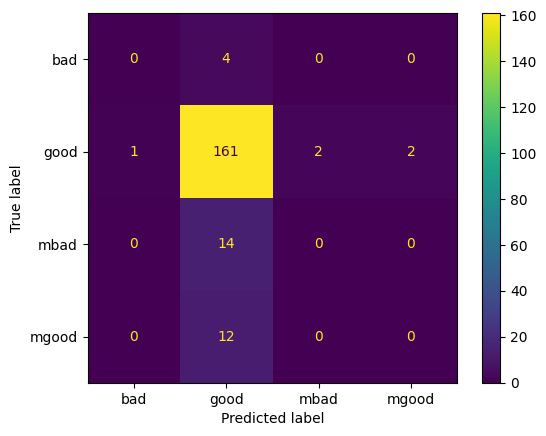

In [87]:
best_clf = grid.best_estimator_
best_clf.fit(X_train, y_train)

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_clf.predict(X_test)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()